In [1]:
import torch
import onnxruntime
import numpy as np
import torch
from rendernet_amd_block import CSTEncoder
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from einops import rearrange

c:\Users\Jack\.conda\envs\ryzenai-transformers\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the trained encoder and decoder modules

In [2]:
# load the encoder
encoder=CSTEncoder(8,embed_dim=256)
ckpt=torch.load('encoder_cst_para.pth')
encoder.load_state_dict(ckpt)
# load the RenderNet
sess_options=onnxruntime.SessionOptions()
sess_options.graph_optimization_level=onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
decoder = onnxruntime.InferenceSession(
                'quantization\quantization_results_512\Sequential_int.onnx',
                sess_options=sess_options,
                providers=["VitisAIExecutionProvider"],
                provider_options=[{"config_file":r"vaip_config.json"}],)

In [3]:
# read the image
trans=transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(1,1,1))])
img_list=['ILSVRC2012_val_00001106.JPEG','ILSVRC2012_val_00032775.JPEG','ILSVRC2012_val_00045087.JPEG']
img_tensor=torch.stack([trans(Image.open(i)) for i in img_list])

In [4]:
def ShowTensorResult(ax,img_single,mean,std,title):
    ax.imshow(img_single.detach().numpy().transpose(1,2,0)*std+mean)
    ax.axis('off')
    ax.set_title(title)
def ShowNumpyResult(ax,img_single,mean,std,title):
    ax.imshow(img_single.transpose(1,2,0)*std+mean)
    ax.axis('off')
    ax.set_title(title)

Show the results of seperating the color, shape, and texture features

In [5]:
patch_embed,patch_img,patch_res=encoder(img_tensor,False)
patch_res=rearrange(patch_res,'b (c hp wp) h w->b c (h hp) (w wp)',hp=8,wp=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


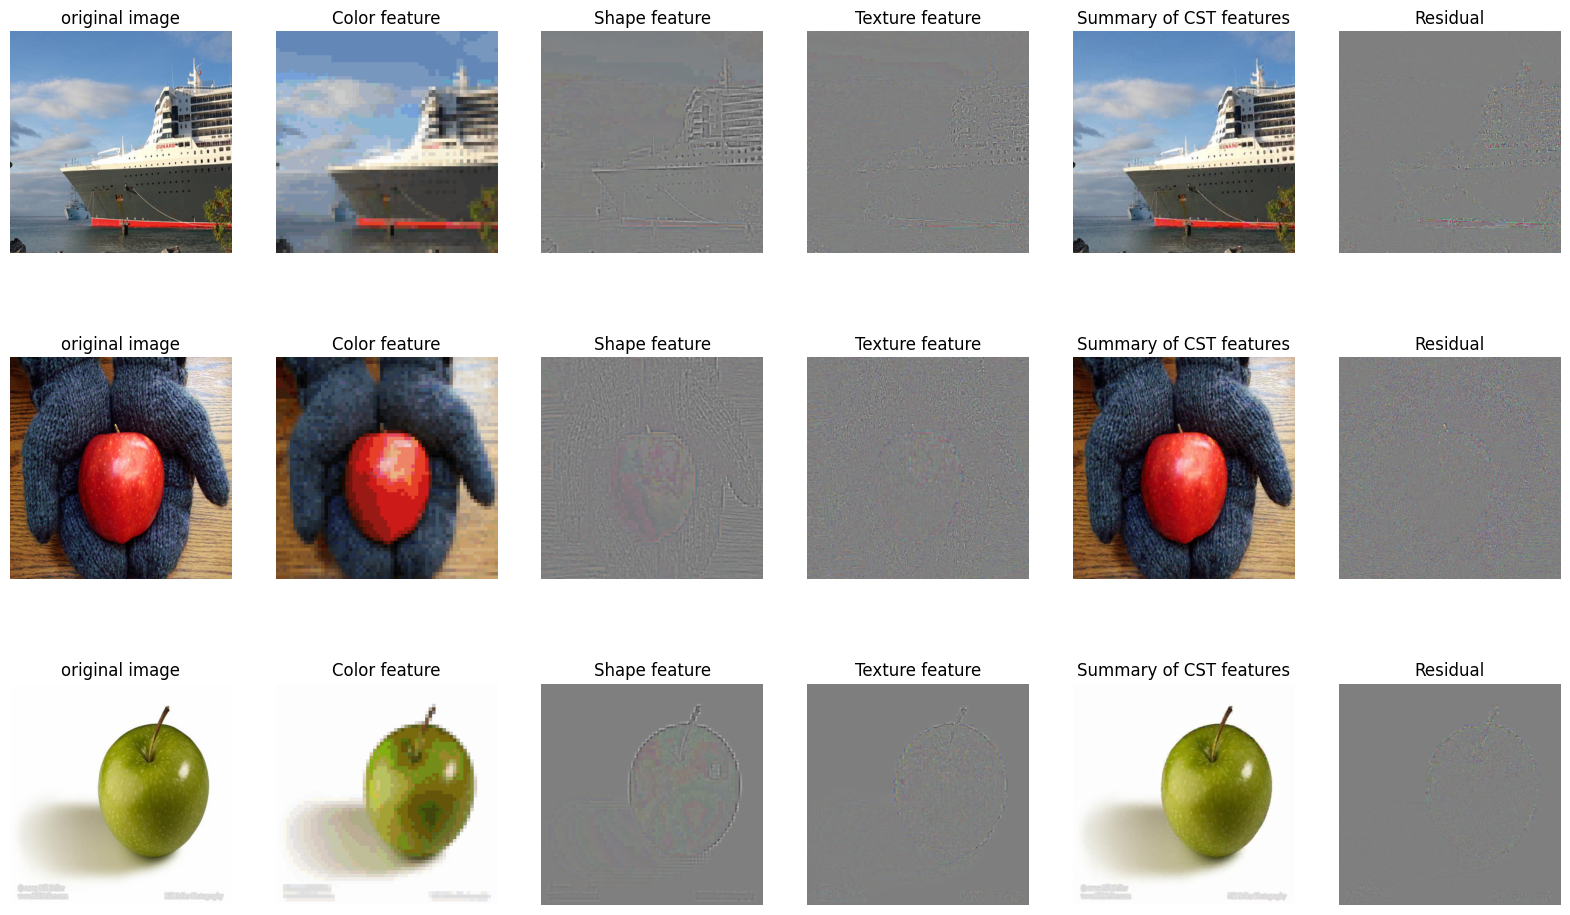

In [6]:
fig,ax=plt.subplots(3,6,figsize=(20,12))
for i in range(3):
    ShowTensorResult(ax[i][0],img_tensor[i],0.5,1,'original image')
    ShowTensorResult(ax[i][1],patch_img[0][i],0.5,1,'Color feature')
    ShowTensorResult(ax[i][2],patch_img[1][i],0.5,0.5,'Shape feature')
    ShowTensorResult(ax[i][3],patch_img[2][i],0.5,1,'Texture feature')
    ShowTensorResult(ax[i][4],sum(patch_img)[i],0.5,1,'Summary of CST features')
    ShowTensorResult(ax[i][5],patch_res[i],0.5,1,'Residual')


Reconstruct the images from the latent patch embeddings

In [7]:
reconstruct_img_list=[]
for i in sum(patch_embed):
    ort_inputs={decoder.get_inputs()[0].name:i.unsqueeze(0).detach().numpy().astype(np.float32)}
    out = np.clip(decoder.run(None,ort_inputs), -1, 1)
    reconstruct_img_list.append(out)

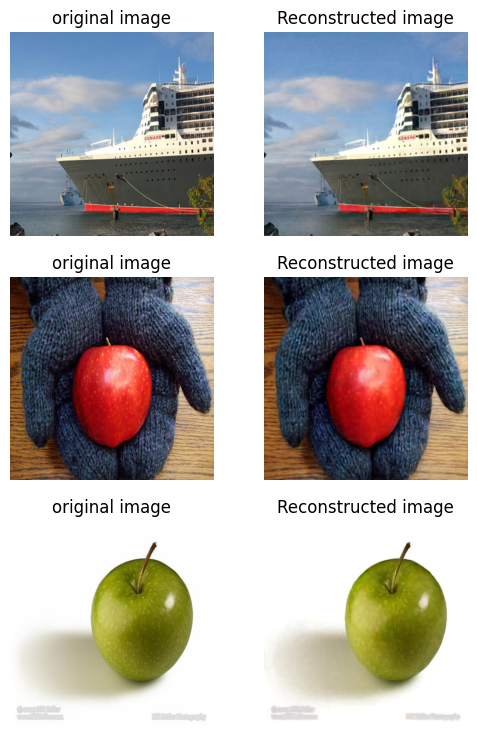

In [8]:
fig,ax=plt.subplots(3,2,figsize=(6,9))
for i in range(3):
    ShowTensorResult(ax[i][0],img_tensor[i],0.5,1,'original image')
    ShowNumpyResult(ax[i][1],reconstruct_img_list[i][0][0],0.5,0.5,'Reconstructed image')